In [2]:
#load libraries 
import time,os
from matplotlib.offsetbox import AnchoredText
import sys,pandas as pd, matplotlib , matplotlib.pyplot as plt, matplotlib.lines , numpy as np,cupy as cp, math, pylab
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
#import cudf
#import ROOT
#from ROOT import TFile

#import root_pandas

#from toggle_cell import hide_cell 
import uproot3
%matplotlib inline

#presets for plot style
from scipy.constants import golden
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (7, 7/golden),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)
#tf.config.experimental.set_memory_growth(physical_devices[1], True)

import root_pandas,glob
from scipy.optimize import curve_fit

import misc_util

/home/sebouh/.local/lib/python3.8/site-packages/uproot3/__init__.py:127: FutureWarning: Consider switching from 'uproot3' to 'uproot', since the new interface became the default in 2020.

    pip install -U uproot

In Python:

    >>> import uproot
    >>> with uproot.open(...) as file:
    ...

  warnings.warn(
/home/sebouh/.local/lib/python3.8/site-packages/awkward0/__init__.py:12: FutureWarning: Consider switching from 'awkward0' to 'awkward', since the new interface became the default in 2020.

    pip install -U awkward

In Python:

    >>> import awkward as ak
    >>> new_style_array = ak.from_awkward0(old_style_array)
    >>> old_style_array = ak.to_awkward0(new_style_array)

  warnings.warn(


Welcome to JupyROOT 6.22/06


In [3]:
inb_same=root_pandas.read_root(glob.glob('/home/sebouh/tuples_hadd/inbend_dihadrons*.root'))

outb_same = root_pandas.read_root(glob.glob('/home/sebouh/tuples_hadd/outbend_dihadrons*.root'))

In [5]:
len(data_dihadrons)

1672821

In [6]:
def mix(df):
    start = time.perf_counter()
    #try:
    N = len(df)

    z2 = df['h2_z']
    pid2 = df['h2_pid']
    def same_bin(i,ii):
        if pid2[i] != pid2[i]:
            return False
        z2i = z2[i]
        z2ii = z2[ii]
        if (z2i<0.12 and z2ii<0.12):
            return True
        elif (z2i<0.25 and z2ii<0.25 and z2i>0.12 and z2ii>0.12):
            return True
        elif (z2i>0.25 and z2ii>0.25):
            return True
        else :
            return False
    
    mixdphi = [0]*N
    mixdphilab = [0]*N
    mixdphilab_truth = [0]*N
    mixdeta = [0]*N
    mixdrap = [0]*N
    mixpt = [0]*N
    mixz2 = [0]*N
    found_mix = [0]*N
    
    ii = 0
    for i in range(N):
        for ii in range(max(0, i-12), max(i-2,0)):
            if same_bin(i,ii):
                found_mix[i] = 1
                break
        mixdphi[i] = df['h1_cm_ph'][i]-df['h2_cm_ph'][ii]
        mixdphilab[i] = df['h1_ph'][i]-df['h2_ph'][ii]
        if 'h1_truth_ph' in df.columns:
            mixdphilab_truth[i] = df['h1_truth_ph'][i]-df['h2_truth_ph'][ii]
        mixdrap[i] = df['h1_cm_rap'][i]-df['h2_cm_rap'][ii]
        mixdeta[i] = df['h1_cm_eta'][i]-df['h2_cm_eta'][ii]
        mixpt[i] = df['h2_cm_pt'][ii]
        mixz2[i] = df['h2_z'][ii]
        if i % 10000 == 0:
            duration = time.perf_counter()-start
            print("%.1f"%(i/N*100),"% complete, time so far: ",duration//3600,"hours", 
                  (duration//60)%60, "minutes", int(duration % 60), "seconds")
    
    df['mix_diff_phi'] = mixdphi
    df['mix_diff_phi_lab'] = mixdphilab
    if 'h1_truth_ph' in df.columns:
        df['mix_diff_phi_lab_truth'] = mixdphilab_truth
    
    df['mix_diff_eta'] = mixdphi
    df['mix_diff_rap'] = mixdrap
    df['mix_h2_pt'] = mixpt
    df['mix_h2_z'] = mixz2
    df['mix_found'] = found_mix
    
    duration = time.perf_counter()-start
    print("total time: ",duration//3600,"hours", (duration//60)%60, "minutes", int(duration % 60), "seconds")
    os.system('say "your program has finished"')
    print("%.5f"%(100*np.mean(df['mix_found']!=0)),"% of the events have been mixed")         

In [6]:
#new version
def mix_v2(df,binvars=''.split(), nbins=1,maxEvents=None):
    start = time.perf_counter()
    #try:
    N = len(df)
    if maxEvents != None:
        N = min(N, maxEvents)
    pid2 = df['h2_pid']
    Q2 = df['Q2']
    partitions = {}
    for var in binvars:
        partitions[var] = [df[var].quantile(i/3) for i in range(nbins+1)]
    
    def same_bin(i,j):
        #print("checking ", i, j)
        if pid2[i] != pid2[j]:
            return False
        if Q2[i] == Q2[j]: #don't mix with the same event
            return False
        for var in binvars:
            good = False
            xi = df[var][i]
            xj = df[var][j]
            pvar = partitions[var]
            for b in range(nbins):
                if xi >= pvar[b] and xi < pvar[b+1] and\
                        xj >= pvar[b] and xj < pvar[b+1]:
                    good=True
                    break
            if not good:
                return False
        return True
            
    mixdphi = [0]*len(df)
    mixdphilab = [0]*len(df)
    mixdphilab_truth = [0]*len(df)
    mixdeta = [0]*len(df)
    mixdrap = [0]*len(df)
    mixpt = [0]*len(df)
    mixz2 = [0]*len(df)
    found_mix = [0]*len(df)
    skippedEvents = [0]*len(df)
    
    ii = 0
    #print(N)
    for i in range(N):
        for di in range(1,300):
            j = i-di
            #print(i,j)
            if j <= 0:
                break
            if same_bin(i,j):
                found_mix[i] = di
                break
        if found_mix[i] == 0:
            continue
        skippedEvents[i] = di-1
        mixdphi[i] = df['h1_cm_ph'][i]-df['h2_cm_ph'][j]
        mixdphilab[i] = df['h1_ph'][i]-df['h2_ph'][j]
        if 'h1_truth_ph' in df.columns:
            mixdphilab_truth[i] = df['h1_truth_ph'][i]-df['h2_truth_ph'][j]
        mixdrap[i] = df['h1_cm_rap'][i]-df['h2_cm_rap'][j]
        mixdeta[i] = df['h1_cm_eta'][i]-df['h2_cm_eta'][j]
        mixpt[i] = df['h2_cm_pt'][j]
        mixz2[i] = df['h2_z'][j]
        if i % 10000 == 0:
            duration = time.perf_counter()-start
            print("%.1f"%(i/N*100),"% complete, time so far: ",duration//3600,"hours", 
                  (duration//60)%60, "minutes", int(duration % 60), "seconds")
    
    df['mix_diff_phi'] = mixdphi
    df['mix_diff_phi_lab'] = mixdphilab
    if 'h1_truth_ph' in df.columns:
        df['mix_diff_phi_lab_truth'] = mixdphilab_truth
    
    df['mix_diff_eta'] = mixdphi
    df['mix_diff_rap'] = mixdrap
    df['mix_h2_pt'] = mixpt
    df['mix_h2_z'] = mixz2
    df['mix_found'] = found_mix
    df['mix_skipped_events'] = skippedEvents
    
    duration = time.perf_counter()-start
    print("total time: ",duration//3600,"hours", (duration//60)%60, "minutes", int(duration % 60), "seconds")
    os.system('say "your program has finished"')
    print("%.5f"%(100*np.mean(df['mix_found']!=0)),"% of the events have been mixed")         

In [7]:
mix_v2(data_dihadrons)
mix_v2(mc_dihadrons)

0.6 % complete, time so far:  0.0 hours 0.0 minutes 2 seconds
1.2 % complete, time so far:  0.0 hours 0.0 minutes 4 seconds
1.8 % complete, time so far:  0.0 hours 0.0 minutes 7 seconds
2.4 % complete, time so far:  0.0 hours 0.0 minutes 9 seconds
3.0 % complete, time so far:  0.0 hours 0.0 minutes 11 seconds
3.6 % complete, time so far:  0.0 hours 0.0 minutes 14 seconds
4.2 % complete, time so far:  0.0 hours 0.0 minutes 16 seconds
4.8 % complete, time so far:  0.0 hours 0.0 minutes 19 seconds
5.4 % complete, time so far:  0.0 hours 0.0 minutes 21 seconds
6.0 % complete, time so far:  0.0 hours 0.0 minutes 23 seconds
6.6 % complete, time so far:  0.0 hours 0.0 minutes 26 seconds
7.2 % complete, time so far:  0.0 hours 0.0 minutes 28 seconds
7.8 % complete, time so far:  0.0 hours 0.0 minutes 31 seconds
8.4 % complete, time so far:  0.0 hours 0.0 minutes 33 seconds
9.0 % complete, time so far:  0.0 hours 0.0 minutes 36 seconds
9.6 % complete, time so far:  0.0 hours 0.0 minutes 38 seco

77.7 % complete, time so far:  0.0 hours 5.0 minutes 18 seconds
78.3 % complete, time so far:  0.0 hours 5.0 minutes 20 seconds
78.9 % complete, time so far:  0.0 hours 5.0 minutes 23 seconds
79.5 % complete, time so far:  0.0 hours 5.0 minutes 25 seconds
80.1 % complete, time so far:  0.0 hours 5.0 minutes 28 seconds
80.7 % complete, time so far:  0.0 hours 5.0 minutes 30 seconds
81.3 % complete, time so far:  0.0 hours 5.0 minutes 33 seconds
81.9 % complete, time so far:  0.0 hours 5.0 minutes 35 seconds
82.5 % complete, time so far:  0.0 hours 5.0 minutes 37 seconds
83.1 % complete, time so far:  0.0 hours 5.0 minutes 40 seconds
83.7 % complete, time so far:  0.0 hours 5.0 minutes 43 seconds
84.3 % complete, time so far:  0.0 hours 5.0 minutes 45 seconds
84.9 % complete, time so far:  0.0 hours 5.0 minutes 48 seconds
85.5 % complete, time so far:  0.0 hours 5.0 minutes 50 seconds
86.1 % complete, time so far:  0.0 hours 5.0 minutes 53 seconds
86.7 % complete, time so far:  0.0 hours

11.5 % complete, time so far:  0.0 hours 4.0 minutes 36 seconds
11.6 % complete, time so far:  0.0 hours 4.0 minutes 39 seconds
11.7 % complete, time so far:  0.0 hours 4.0 minutes 43 seconds
11.8 % complete, time so far:  0.0 hours 4.0 minutes 46 seconds
12.0 % complete, time so far:  0.0 hours 4.0 minutes 49 seconds
12.1 % complete, time so far:  0.0 hours 4.0 minutes 52 seconds
12.2 % complete, time so far:  0.0 hours 4.0 minutes 55 seconds
12.3 % complete, time so far:  0.0 hours 4.0 minutes 58 seconds
12.5 % complete, time so far:  0.0 hours 5.0 minutes 1 seconds
12.6 % complete, time so far:  0.0 hours 5.0 minutes 4 seconds
12.7 % complete, time so far:  0.0 hours 5.0 minutes 7 seconds
12.8 % complete, time so far:  0.0 hours 5.0 minutes 10 seconds
13.0 % complete, time so far:  0.0 hours 5.0 minutes 13 seconds
13.1 % complete, time so far:  0.0 hours 5.0 minutes 16 seconds
13.2 % complete, time so far:  0.0 hours 5.0 minutes 19 seconds
13.3 % complete, time so far:  0.0 hours 5.

27.5 % complete, time so far:  0.0 hours 11.0 minutes 12 seconds
27.6 % complete, time so far:  0.0 hours 11.0 minutes 15 seconds
27.8 % complete, time so far:  0.0 hours 11.0 minutes 18 seconds
27.9 % complete, time so far:  0.0 hours 11.0 minutes 21 seconds
28.0 % complete, time so far:  0.0 hours 11.0 minutes 24 seconds
28.1 % complete, time so far:  0.0 hours 11.0 minutes 27 seconds
28.3 % complete, time so far:  0.0 hours 11.0 minutes 30 seconds
28.4 % complete, time so far:  0.0 hours 11.0 minutes 34 seconds
28.5 % complete, time so far:  0.0 hours 11.0 minutes 37 seconds
28.6 % complete, time so far:  0.0 hours 11.0 minutes 40 seconds
28.8 % complete, time so far:  0.0 hours 11.0 minutes 43 seconds
28.9 % complete, time so far:  0.0 hours 11.0 minutes 46 seconds
29.0 % complete, time so far:  0.0 hours 11.0 minutes 49 seconds
29.1 % complete, time so far:  0.0 hours 11.0 minutes 52 seconds
29.3 % complete, time so far:  0.0 hours 11.0 minutes 55 seconds
29.4 % complete, time so 

43.3 % complete, time so far:  0.0 hours 17.0 minutes 39 seconds
43.5 % complete, time so far:  0.0 hours 17.0 minutes 42 seconds
43.6 % complete, time so far:  0.0 hours 17.0 minutes 45 seconds
43.7 % complete, time so far:  0.0 hours 17.0 minutes 48 seconds
43.8 % complete, time so far:  0.0 hours 17.0 minutes 51 seconds
44.0 % complete, time so far:  0.0 hours 17.0 minutes 54 seconds
44.1 % complete, time so far:  0.0 hours 17.0 minutes 57 seconds
44.2 % complete, time so far:  0.0 hours 18.0 minutes 0 seconds
44.3 % complete, time so far:  0.0 hours 18.0 minutes 3 seconds
44.5 % complete, time so far:  0.0 hours 18.0 minutes 6 seconds
44.6 % complete, time so far:  0.0 hours 18.0 minutes 9 seconds
44.7 % complete, time so far:  0.0 hours 18.0 minutes 12 seconds
44.8 % complete, time so far:  0.0 hours 18.0 minutes 15 seconds
45.0 % complete, time so far:  0.0 hours 18.0 minutes 18 seconds
45.1 % complete, time so far:  0.0 hours 18.0 minutes 21 seconds
45.2 % complete, time so far:

59.2 % complete, time so far:  0.0 hours 24.0 minutes 6 seconds
59.3 % complete, time so far:  0.0 hours 24.0 minutes 9 seconds
59.4 % complete, time so far:  0.0 hours 24.0 minutes 12 seconds
59.5 % complete, time so far:  0.0 hours 24.0 minutes 15 seconds
59.7 % complete, time so far:  0.0 hours 24.0 minutes 18 seconds
59.8 % complete, time so far:  0.0 hours 24.0 minutes 21 seconds
59.9 % complete, time so far:  0.0 hours 24.0 minutes 24 seconds
60.0 % complete, time so far:  0.0 hours 24.0 minutes 27 seconds
60.2 % complete, time so far:  0.0 hours 24.0 minutes 30 seconds
60.3 % complete, time so far:  0.0 hours 24.0 minutes 33 seconds
60.4 % complete, time so far:  0.0 hours 24.0 minutes 36 seconds
60.5 % complete, time so far:  0.0 hours 24.0 minutes 39 seconds
60.7 % complete, time so far:  0.0 hours 24.0 minutes 42 seconds
60.8 % complete, time so far:  0.0 hours 24.0 minutes 45 seconds
60.9 % complete, time so far:  0.0 hours 24.0 minutes 48 seconds
61.0 % complete, time so fa

75.0 % complete, time so far:  0.0 hours 30.0 minutes 32 seconds
75.1 % complete, time so far:  0.0 hours 30.0 minutes 35 seconds
75.2 % complete, time so far:  0.0 hours 30.0 minutes 38 seconds
75.4 % complete, time so far:  0.0 hours 30.0 minutes 41 seconds
75.5 % complete, time so far:  0.0 hours 30.0 minutes 44 seconds
75.6 % complete, time so far:  0.0 hours 30.0 minutes 47 seconds
75.7 % complete, time so far:  0.0 hours 30.0 minutes 50 seconds
75.8 % complete, time so far:  0.0 hours 30.0 minutes 53 seconds
76.0 % complete, time so far:  0.0 hours 30.0 minutes 56 seconds
76.1 % complete, time so far:  0.0 hours 30.0 minutes 59 seconds
76.2 % complete, time so far:  0.0 hours 31.0 minutes 2 seconds
76.3 % complete, time so far:  0.0 hours 31.0 minutes 5 seconds
76.5 % complete, time so far:  0.0 hours 31.0 minutes 8 seconds
76.6 % complete, time so far:  0.0 hours 31.0 minutes 11 seconds
76.7 % complete, time so far:  0.0 hours 31.0 minutes 14 seconds
76.8 % complete, time so far

90.9 % complete, time so far:  0.0 hours 37.0 minutes 1 seconds
91.0 % complete, time so far:  0.0 hours 37.0 minutes 4 seconds
91.2 % complete, time so far:  0.0 hours 37.0 minutes 7 seconds
91.3 % complete, time so far:  0.0 hours 37.0 minutes 10 seconds
91.4 % complete, time so far:  0.0 hours 37.0 minutes 13 seconds
91.5 % complete, time so far:  0.0 hours 37.0 minutes 16 seconds
91.7 % complete, time so far:  0.0 hours 37.0 minutes 19 seconds
91.8 % complete, time so far:  0.0 hours 37.0 minutes 22 seconds
91.9 % complete, time so far:  0.0 hours 37.0 minutes 25 seconds
92.0 % complete, time so far:  0.0 hours 37.0 minutes 28 seconds
92.2 % complete, time so far:  0.0 hours 37.0 minutes 31 seconds
92.3 % complete, time so far:  0.0 hours 37.0 minutes 34 seconds
92.4 % complete, time so far:  0.0 hours 37.0 minutes 37 seconds
92.5 % complete, time so far:  0.0 hours 37.0 minutes 41 seconds
92.7 % complete, time so far:  0.0 hours 37.0 minutes 44 seconds
92.8 % complete, time so far

In [17]:

def shift_angle(dphi):
    tmp = dphi + (dphi<-np.pi/2)*2*np.pi - (dphi>3*np.pi/2)*2*np.pi
    print(min(tmp),max(tmp))
    return tmp
for df in data_dihadrons, mc_dihadrons:
    df['mix_diff_phi_shift'] = shift_angle(df['mix_diff_phi'])
    df['diff_phi_shift'] = shift_angle(df['diff_phi_cm'])

    df['mix_diff_phi_shift_lab'] = shift_angle(df['mix_diff_phi_lab'])
    df['diff_phi_shift_lab'] = shift_angle(df['h1_ph']-df['h2_ph'])
    if 'h1_truth_ph' in df.columns:
        df['mix_diff_phi_shift_lab_truth'] = shift_angle(df['mix_diff_phi_lab_truth'])
        df['diff_phi_shift_lab_truth'] = shift_angle(df['h1_truth_ph']- df['h2_truth_ph'])

-1.5707914957558284 4.712383689769264
-1.5707954122379277 4.712382594809183
-1.5707907896969324 4.712369171327582
-1.570794727117315 4.71238816972218
-1.570796173847444 4.712388900563752
-1.5707963086100087 4.71238702823957
-1.570795343146736 4.712387696223423
-1.5707955300052892 4.712388560258017
-1.5707963267948966 4.712383507881582
-1.5707963267948966 4.712312510250579


In [78]:
pd.to_pickle(data_dihadrons,"../in/data_dihadrons_30pc_mix.pkl")
pd.to_pickle(mc_dihadrons,"../in/mc_dihadrons_mix.pkl")

In [ ]:
data_dihadrons = pd.read_pickle("../in/data_dihadrons_30pc_mix.pkl")
mc_dihadrons = pd.read_pickle("../in/mc_dihadrons_mix.pkl")

In [ ]:
for df0 in data_dihadrons, mc_dihadrons:
    df.histogram

0.9945984875765215


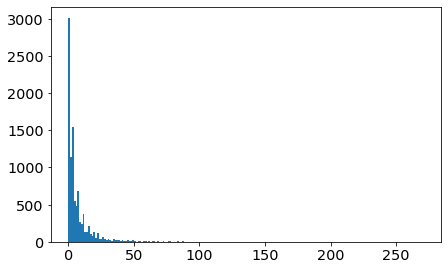

In [22]:
plt.hist(data_dihadrons[:10000].mix_skipped_events, bins=200)

df = data_dihadrons[:10000]
print(len(df.query("mix_skipped_events >0 and mix_skipped_events <100"))/len(df.query("mix_skipped_events >0 and mix_skipped_events <200")))

In [ ]:
#use pseudorapidity since rapidity isn't in the mc tuples yet
#mc_dihadrons['h1_cm_rap']= mc_dihadrons['h1_cm_eta']
#mc_dihadrons['h2_cm_rap']= mc_dihadrons['h2_cm_eta']
#mix(mc_dihadrons)

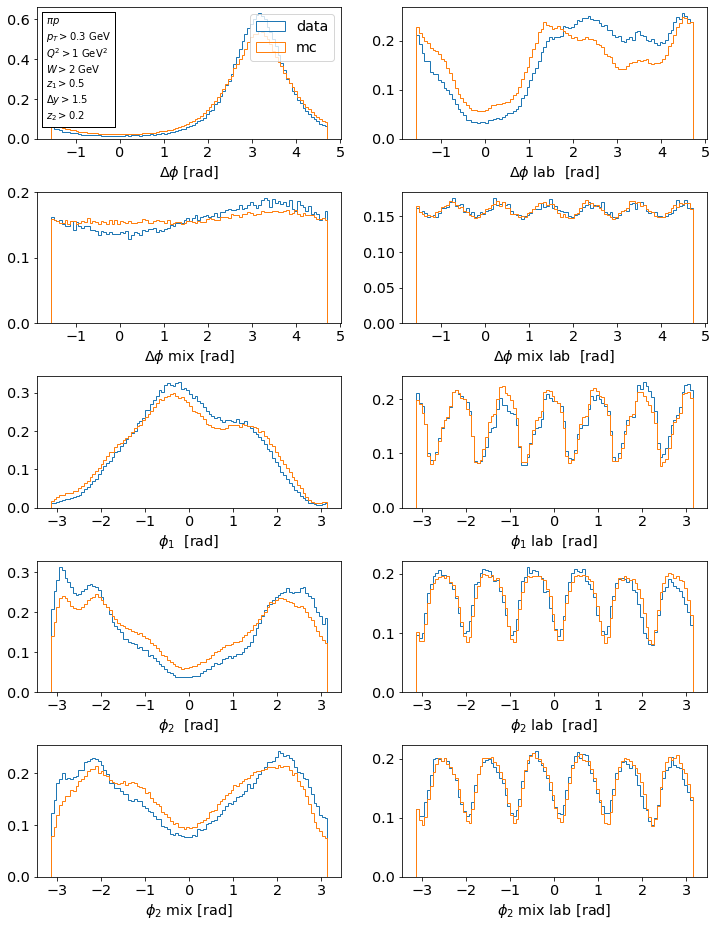

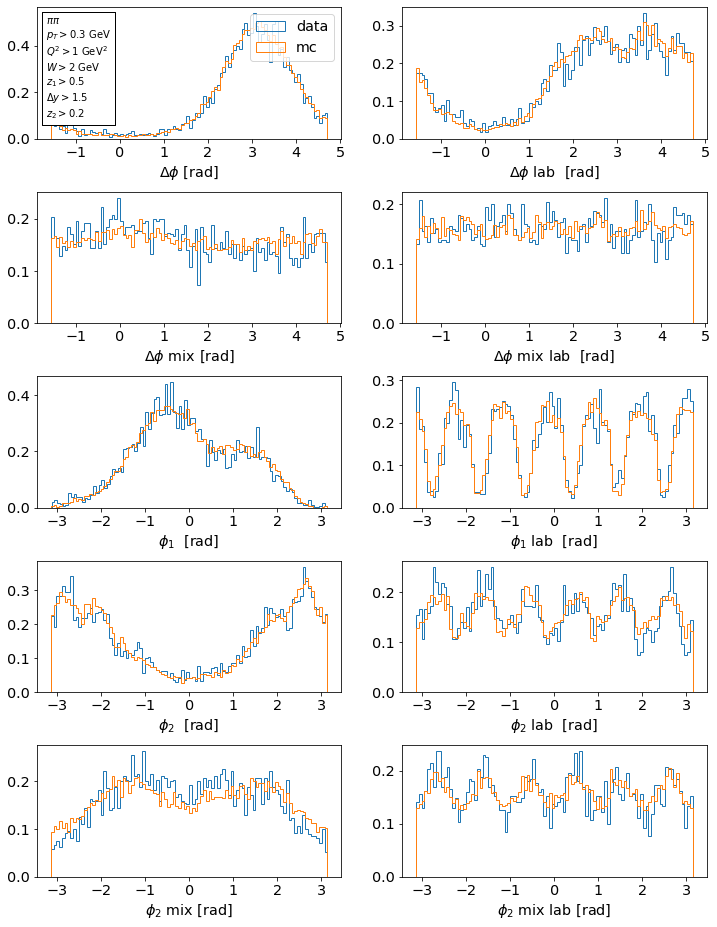

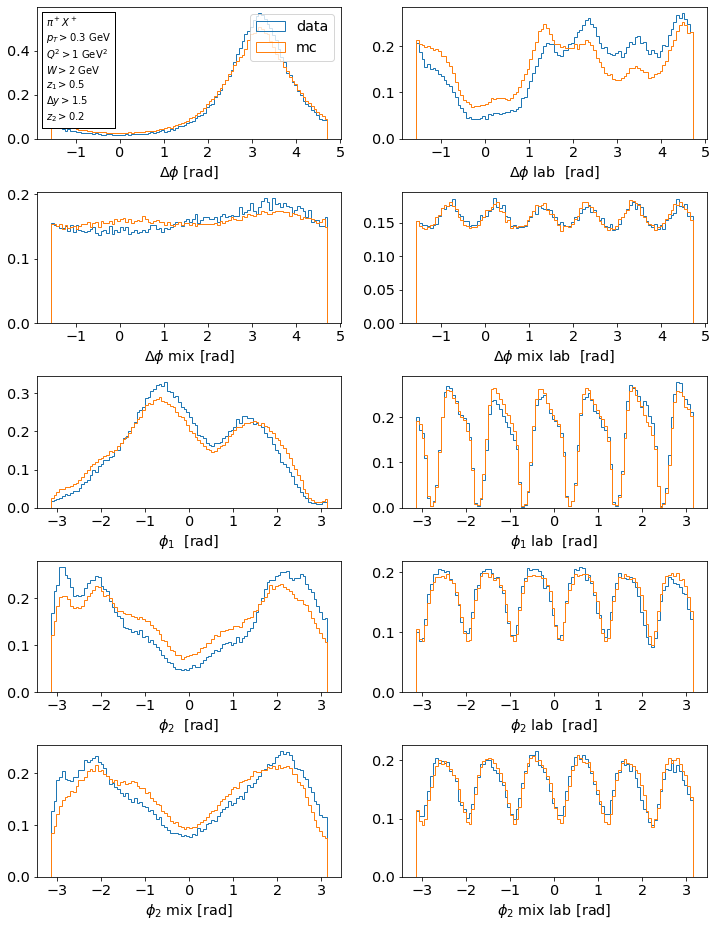

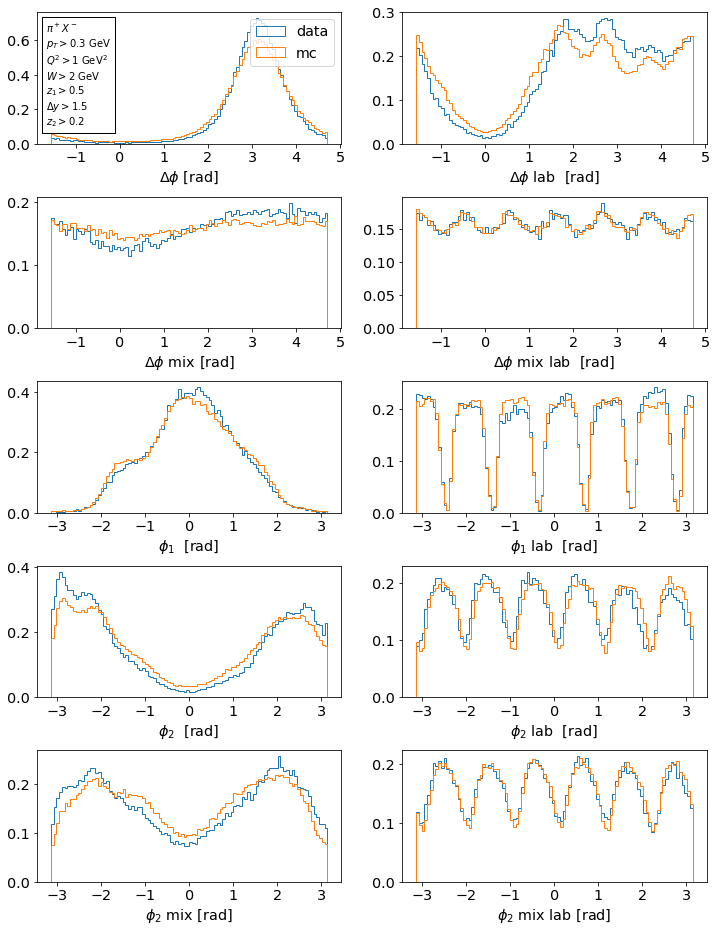

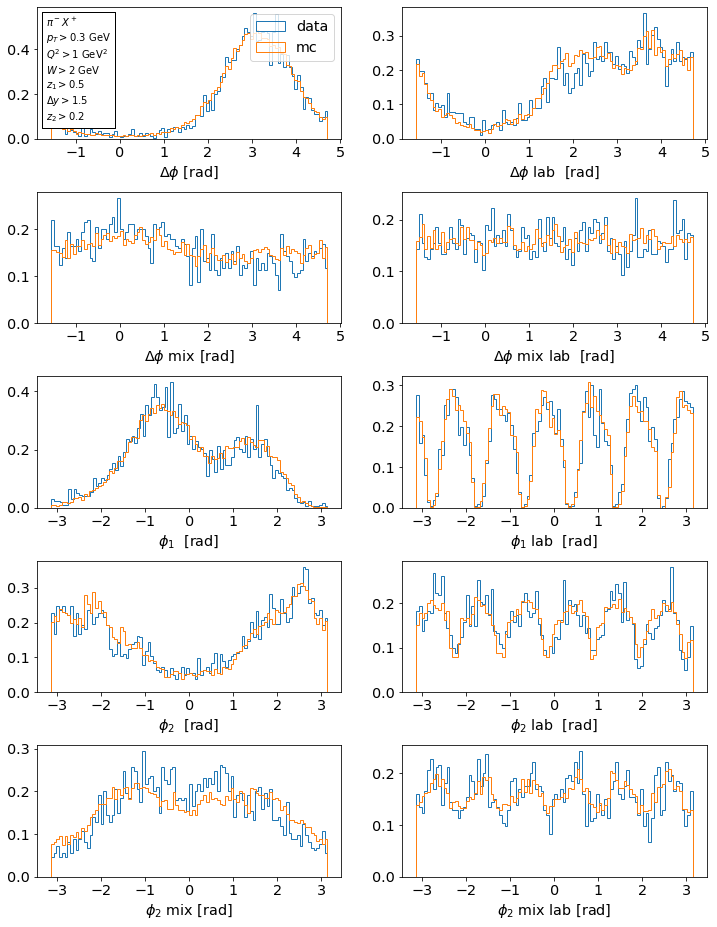

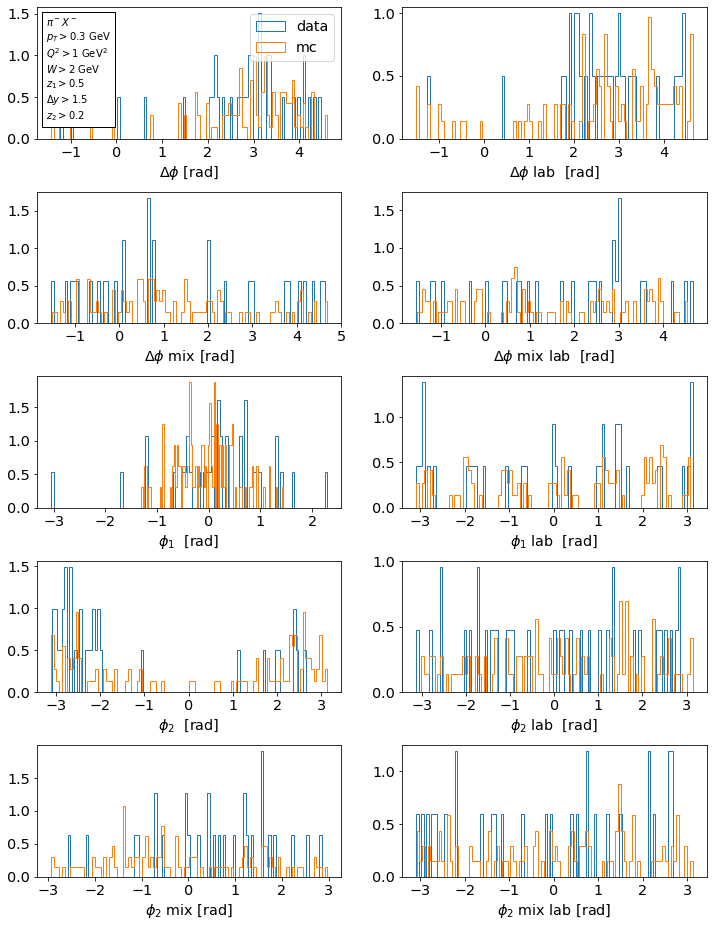

In [77]:
for addQuery, tag, label in [("h2_pid == 2212", "_pi_p","$\pi p$"),
                        ("abs(h2_pid) == 211","_pi_pi","$\pi\pi$"),
                        ("h2_pid > 0 and h1_pid > 0", "_++", "$\pi^+X^+$"),
                        ("h2_pid > 0 and h1_pid < 0", "_+-", "$\pi^+X^-$"),
                        ("h2_pid < 0 and h1_pid > 0", "_-+", "$\pi^-X^+$"),
                        ("h2_pid < 0 and h1_pid < 0", "_--", "$\pi^-X^-$")]:
    fig,axs = plt.subplots(5,2, figsize=(12,16))
    for df in data_dihadrons, mc_dihadrons:
        df = df.query('h2_z>0.2 and h2_cm_pt>0.3 and h1_cm_pt>0.3 and diff_rap_cm> 1.5 and '+addQuery)
        axs[0][0].hist(df.diff_phi_shift,bins=100,histtype='step',density='true')
        axs[0][0].set_xlabel("$\Delta\phi$ [rad]")
        axs[0][0].add_artist(AnchoredText(label + "\n$p_T>0.3$ GeV\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$z_1>0.5$\n$\\Delta y>1.5$\n$z_2>0.2$",loc='upper left'))


        axs[1][0].hist(df.query('mix_found > 0').mix_diff_phi_shift,bins=100,histtype='step',density='true')
        axs[1][0].set_xlabel("$\Delta\phi$ mix [rad]")
        axs[2][0].hist(df.h1_cm_ph,bins=100,histtype='step',density='true')
        axs[2][0].set_xlabel("$\phi_1$  [rad]")
        axs[3][0].hist(df.h2_cm_ph,bins=100,histtype='step',density='true')
        axs[3][0].set_xlabel("$\phi_2$  [rad]")
        axs[4][0].hist(df.query('mix_found > 0').eval('h1_cm_ph - mix_diff_phi'),bins=100,histtype='step',density='true')
        axs[4][0].set_xlabel("$\phi_2$ mix [rad]")
        axs[0][1].hist(df.diff_phi_shift_lab,bins=100,histtype='step',density='true')
        axs[0][1].set_xlabel("$\Delta\phi$ lab  [rad]")
        axs[1][1].hist(df.query('mix_found > 0').mix_diff_phi_shift_lab,bins=100,histtype='step',density='true')
        axs[1][1].set_xlabel("$\Delta\phi$ mix lab  [rad]")
        axs[2][1].hist(df.h1_ph,bins=100,histtype='step',density='true')
        axs[2][1].set_xlabel("$\phi_1$ lab  [rad]")
        axs[3][1].hist(df.h2_ph,bins=100,histtype='step',density='true')
        axs[3][1].set_xlabel("$\phi_2$ lab  [rad]")
        axs[4][1].hist(df.query('mix_found > 0').eval('h1_ph - mix_diff_phi_lab'),bins=100,histtype='step',density='true')
        axs[4][1].set_xlabel("$\phi_2$ mix lab [rad]")
    axs[0][0].legend(labels='data mc'.split())
    fig.subplots_adjust(hspace=0.4)
    plt.savefig("../images/mixing_phi"+tag+".pdf")
    

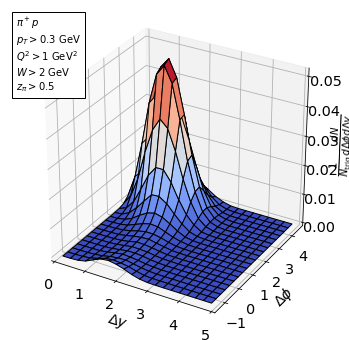

In [79]:

def dphi_deta_plot(df,df_trig,deta_range=(-2,6),bins=20,fig=None):
    dphi_range = (-np.pi/2,3*np.pi/2)
    x = df.diff_rap_cm
    y = df.diff_phi_shift
    if fig == None:
        fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')
    hist, xedges, yedges = np.histogram2d(x, y, bins=bins, range=[deta_range, dphi_range])
    
    denom = len(df_trig)*2*np.pi/bins*(deta_range[1]-deta_range[0])/bins
    hist = np.divide(hist, denom)
    xpos, ypos = np.meshgrid(np.add(xedges[:-1],xedges[1:])/2, np.add(yedges[:-1],yedges[1:])/2)
    zpos = 0

    surf = ax.plot_surface(xpos, ypos, hist.transpose(), cmap=cm.coolwarm,edgecolor='k')
    ax.set_xlabel("$\\Delta y$")
    ax.set_ylabel("$\\Delta\\phi$")
    ax.set_zlabel("$\\frac{1}{N_{\\mathrm{trig}}}\\frac{dN}{d\\Delta\\phi d\\Delta y}$",rotation=-90)
    ax.set_xlim(*deta_range)
    ax.set_ylim(*dphi_range)
    return fig,ax
df = data_dihadrons.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                         + "and h2_pid == 2212")
df_trig = data_triggers.query("h_cm_pt>0.3")
fig,ax = dphi_deta_plot(df,df_trig,
              deta_range=(0,5))
plt.gca().add_artist(AnchoredText("$\pi^+p$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$z_\\pi>0.5$",loc='upper left'))
plt.savefig("../images/dphi_vs_deta_pip_p.pdf",bbox_inches='tight')
plt.show()

In [80]:
def dphi_deta_plot_3(df,df_trig,deta_range=(-2,3),bins=20,fig=None):
    dphi_range = (-np.pi/2,3*np.pi/2)
    if fig == None:
        fig = plt.figure(figsize=(18,6))
    ax1 = fig.add_subplot(131, projection='3d')
    
    denom = len(df_trig)*2*np.pi/bins*(deta_range[1]-deta_range[0])/bins
    hist1, xedges, yedges = np.histogram2d(df.diff_rap_cm, df.diff_phi_shift, bins=bins, range=[deta_range, dphi_range])
    hist1 = np.divide(hist1, denom)
    print(xedges)
    dfq = df.query("mix_found == 1")
    hist2, xedges, yedges = np.histogram2d(dfq.mix_diff_rap, dfq.mix_diff_phi, bins=bins, range=[deta_range, dphi_range])
    hist2 = np.divide(hist2,denom)
    
    hist3 = np.divide(hist1,hist2)
    
    xpos, ypos = np.meshgrid(np.add(xedges[:-1],xedges[1:])/2, np.add(yedges[:-1],yedges[1:])/2)
    zpos = 0

    surf = ax1.plot_surface(xpos, ypos, hist1.transpose(), cmap=cm.coolwarm,edgecolor='k')
    ax1.set_xlabel("$\\Delta y$")
    ax1.set_ylabel("$\\Delta\\phi$")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_title("$\\frac{1}{N_{\\mathrm{trig}}}\\frac{dN}{d\\Delta\\phi d\\Delta y}$",rotation=0)
    ax1.set_xlim(*deta_range)
    ax1.set_ylim(*dphi_range)
    
    
    ax2 = fig.add_subplot(132, projection='3d')
    surf = ax2.plot_surface(xpos, ypos, hist2.transpose(), cmap=cm.coolwarm,edgecolor='k')
    ax2.set_xlabel("$\\Delta y$")
    ax2.set_ylabel("$\\Delta\\phi$")
    ax2.zaxis.set_rotate_label(False)
    ax2.set_title("$\\frac{1}{N_{\\mathrm{trig}}}\\frac{dN}{d\\Delta\\phi d\\Delta y}$ mix",rotation=0)
    ax2.set_xlim(*deta_range)
    ax2.set_ylim(*dphi_range)
    
    
    
    ax3 = fig.add_subplot(133, projection='3d')
    surf = ax3.plot_surface(xpos, ypos, hist3.transpose(), cmap=cm.coolwarm,edgecolor='k')
    ax3.set_xlabel("$\\Delta y$")
    ax3.set_ylabel("$\\Delta\\phi$")
    ax3.zaxis.set_rotate_label(False)
    ax3.set_title("$C(\\Delta\\phi,\\Delta y)$",rotation=0)
    ax3.set_xlim(*deta_range)
    ax3.set_ylim(*dphi_range)
    
    
    return fig,[ax1,ax2,ax3]

[-1.    -0.805 -0.61  -0.415 -0.22  -0.025  0.17   0.365  0.56   0.755
  0.95   1.145  1.34   1.535  1.73   1.925  2.12   2.315  2.51   2.705
  2.9  ]


<ipython-input-80-36dae02d0aab>:15: RuntimeWarning: divide by zero encountered in true_divide
  hist3 = np.divide(hist1,hist2)
<ipython-input-80-36dae02d0aab>:15: RuntimeWarning: invalid value encountered in true_divide
  hist3 = np.divide(hist1,hist2)
<ipython-input-80-36dae02d0aab>:41: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  surf = ax3.plot_surface(xpos, ypos, hist3.transpose(), cmap=cm.coolwarm,edgecolor='k')
/usr/lib/python3/dist-packages/mpl_toolkits/mplot3d/proj3d.py:152: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w
/usr/lib/python3/dist-packages/mpl_toolkits/mplot3d/proj3d.py:152: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w
/usr/lib/python3/dist-packages/mpl_toolkits/mplot3d/proj3d.py:152: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


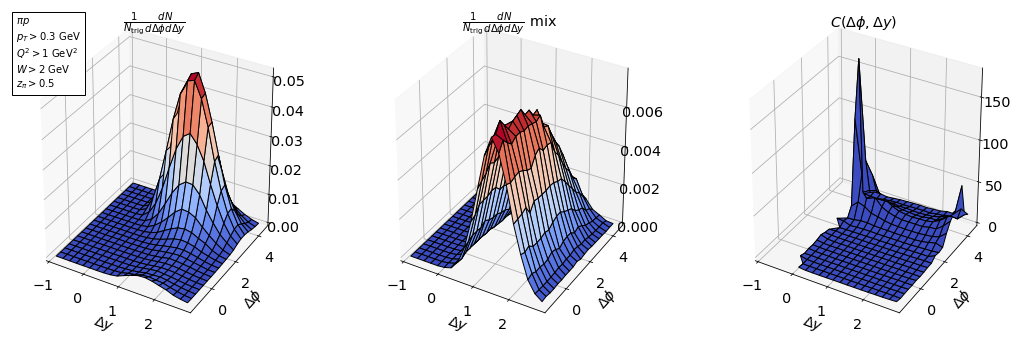

[-1.    -0.805 -0.61  -0.415 -0.22  -0.025  0.17   0.365  0.56   0.755
  0.95   1.145  1.34   1.535  1.73   1.925  2.12   2.315  2.51   2.705
  2.9  ]


<ipython-input-80-36dae02d0aab>:15: RuntimeWarning: divide by zero encountered in true_divide
  hist3 = np.divide(hist1,hist2)
<ipython-input-80-36dae02d0aab>:15: RuntimeWarning: invalid value encountered in true_divide
  hist3 = np.divide(hist1,hist2)
<ipython-input-80-36dae02d0aab>:41: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  surf = ax3.plot_surface(xpos, ypos, hist3.transpose(), cmap=cm.coolwarm,edgecolor='k')
/usr/lib/python3/dist-packages/mpl_toolkits/mplot3d/proj3d.py:152: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w
/usr/lib/python3/dist-packages/mpl_toolkits/mplot3d/proj3d.py:152: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


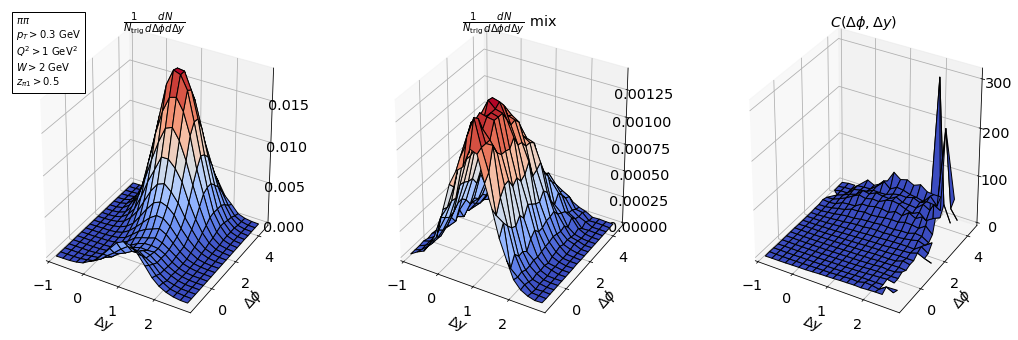

In [81]:
df = data_dihadrons.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                         + "and h2_pid == 2212")
df_trig = data_triggers.query("h_cm_pt>0.3")
fig,axs = dphi_deta_plot_3(df,df_trig,
              deta_range=(-1,2.9))
axs[0].add_artist(AnchoredText("$\pi p$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$z_\\pi>0.5$",loc='upper left'))
plt.savefig("../images/dphi_vs_deta_pi_p.pdf",bbox_inches='tight')
plt.show()

df = data_dihadrons.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                         + "and abs(h2_pid) == 211")
df_trig = data_triggers.query("h_cm_pt>0.3")
fig,axs = dphi_deta_plot_3(df,df_trig,
              deta_range=(-1,2.9))
axs[0].add_artist(AnchoredText("$\pi\pi$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$z_{\\pi1}>0.5$",loc='upper left'))
plt.savefig("../images/dphi_vs_deta_pi_p.pdf",bbox_inches='tight')
plt.show()

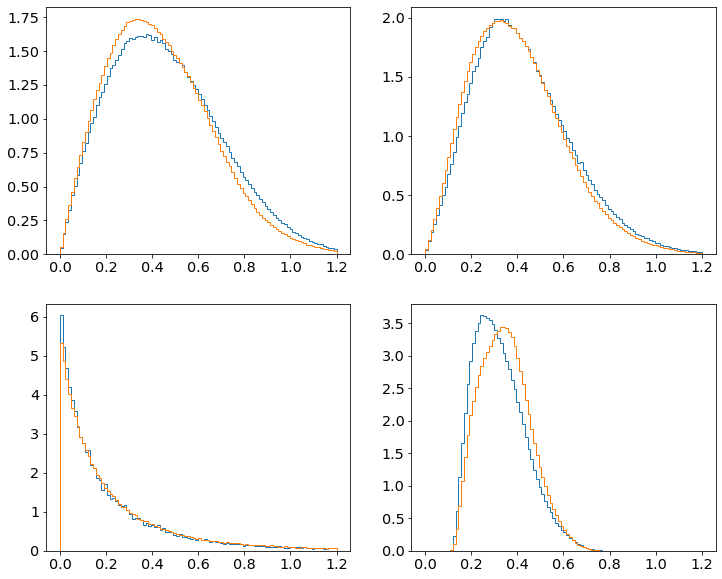

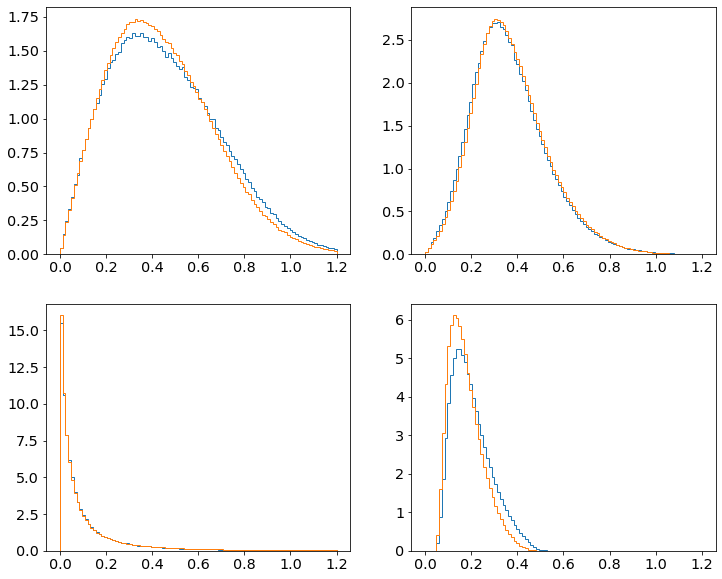

In [95]:

for q in 'h2_pid == 2212', 'abs(h2_pid) == 211':
    fig,axs = plt.subplots(2,2, figsize=(12,10))
    for df in data_dihadrons, mc_dihadrons:
        df = df.query(q)
        axs[0][0].hist(df.h1_cm_pt,density=True,bins=100, histtype='step',range=(0,1.2))
        axs[0][1].hist(df.h2_cm_pt,density=True,bins=100, histtype='step',range=(0,1.2))
        axs[1][0].hist(df.diff_rap_cm-df.diff_eta_cm,density=True,bins=100, histtype='step',range=(0,1.2))
        axs[1][1].hist(df.h2_z,density=True,bins=100, histtype='step',range=(0,1.2))


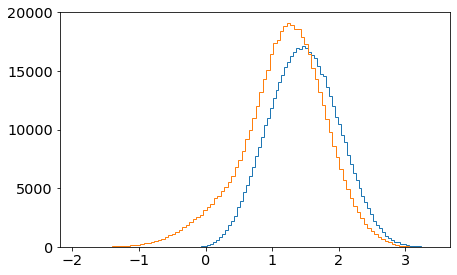

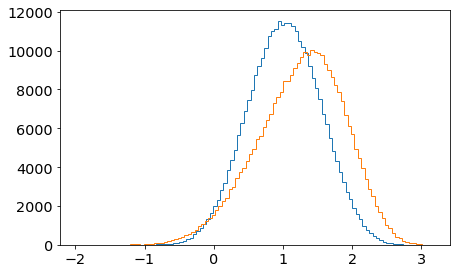

In [79]:
df = data_dihadrons.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                         + "and h2_pid == 2212")
plt.hist(df.diff_rap_cm,bins=100,histtype='step')
plt.hist(df.mix_diff_rap,bins=100,histtype='step')
plt.show()
df = data_dihadrons.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                         + "and abs(h2_pid) == 211")
plt.hist(df.diff_rap_cm,bins=100,histtype='step')
plt.hist(df.mix_diff_rap,bins=100,histtype='step')
plt.show()

In [24]:
import misc_util

def azimuthalPlot(df,df_trig,n=4,bins = 50, includeResiduals=False,includeLegend=True,style='normal',
                 normalize_properly=True,show='corr',frame='cm',truth=False):
    if(includeResiduals):
        fig,axs = plt.subplots(2,1, figsize=(7,7), gridspec_kw={'height_ratios': [3, 1]}, 
                              sharex='all')
        plt.sca(axs[0])
    x,y,dy = [],[],[]
    
    if frame == 'cm':
        diff_phi_shift = df.diff_phi_shift
        mix_diff_phi_shift = df.query('mix_found > 0').mix_diff_phi_shift
    elif frame== 'lab':
        if not truth:
            diff_phi_shift = df.diff_phi_shift_lab
            mix_diff_phi_shift = df.query('mix_found > 0').mix_diff_phi_shift_lab
        else:
            diff_phi_shift = df.diff_phi_shift_lab_truth
            mix_diff_phi_shift = df.query('mix_found > 0').mix_diff_phi_shift_lab_truth
    denom = len(df_trig)*2*np.pi/bins
    y, x = np.histogram(diff_phi_shift, bins=bins, range=(-np.pi/2,3*np.pi/2))
    x = np.add(x[1:],x[:-1])/2
    
    dy = np.sqrt(y)
    ym, _ = np.histogram(mix_diff_phi_shift, bins=bins, range=(-np.pi/2,3*np.pi/2))
    dym = np.sqrt(ym)
    
    y=np.divide(y,denom)
    ym=np.divide(ym,denom)
    dy=np.divide(dy,denom)
    dym=np.divide(dym,denom)
    if show == 'corr':
        dy = y/ym*np.hypot(dy/y, dym/ym)
        y= y/ym
    elif show == 'mix':
        y=ym
        dy = dym
    
    
    if style== 'normal':
        plt.errorbar(x,y,dy,marker='o',color='k',linestyle='')
        plt.axhline(0,color='0.7',linestyle=':')
        #a = [2*sum(y*np.sin(i*x))/len(x) for i in range(0,n+1)]
        #remove sin term
        #a = [0 for i in range(0,n+1)]
        b = [2*sum(y*np.cos(i*x))/len(x) for i in range(0,n+1)]
        b[0]/=2
        s = 0
        for i in range(0,n+1):
            s = b[i]*np.cos(i*x)+s
        plt.plot(x,s,linestyle='-',color='k',label='all')
        for i in range(1,n+1):
            plt.plot(x,b[i]*np.cos(i*x)+b[0]*(i!=0),linestyle='--', label="n=%s"%i)
        plt.gca().set_xlim(-np.pi/2,np.pi*3/2)
        if show == 'same':
            plt.gca().set_ylabel("$\\frac{1}{N_{\\mathrm{trig}}}\\frac{dN}{d\\Delta\\phi}$",rotation=0,fontsize=20,labelpad=25)
        elif show == 'corr' :
            plt.gca().set_ylabel("$C(\\Delta\\phi)$",rotation=0,fontsize=20,labelpad=25)
        elif show == 'mix' :
            plt.gca().set_ylabel("$\\frac{1}{N_{\\mathrm{trig}}}\\frac{dN^{\\mathrm{mix}}}{d\\Delta\\phi}$",rotation=0,fontsize=20,labelpad=25)
                
    elif style=='bar':
        plt.gca().bar(x,y,x[1]-x[0],alpha=0.3,color='tab:pink')
    if not includeResiduals:
        plt.gca().set_xlabel("$\\Delta\\phi$ [rad]")
    if includeLegend:
        legend = plt.gca().legend(title="Fourier fit",loc='upper left')
        plt.setp(legend.get_title(),fontsize=12)
    if includeResiduals:
        plt.sca(axs[1])
        plt.errorbar(x,(y-s)/dy,1,marker='o',color='k',linestyle='')
        plt.gca().set_xlabel("$\\Delta\\phi$ [rad]")
        axs[1].set_ylabel('normed residual')
        #lims = axs[0].get_ylim()
        #axs[1].set_ylim(-(lims[1]-lims[0])/6,(lims[1]-lims[0])/6)
        plt.sca(axs[0])
        plt.subplots_adjust(hspace=0)

In [25]:
def azimuthalPlot_3(df,df_trig,n=4,bins = 50, includeResiduals=False,includeLegend=True,style='normal',
                 normalize_properly=True,frame='cm',truth=False):
    fig,axs = plt.subplots(1,3, figsize=(18,6))
    plt.sca(axs[0])
    azimuthalPlot(df,df_trig,n,bins,includeLegend=True,show='same',frame=frame,truth=truth)
    plt.sca(axs[1])
    axs[0].get_shared_y_axes().join(axs[0], axs[1])
    azimuthalPlot(df,df_trig,n,bins,includeLegend=False,show='mix',frame=frame,truth=truth)
    plt.sca(axs[2])
    azimuthalPlot(df,df_trig,n,bins,includeLegend=False,show='corr',frame=frame,truth=truth)
    return fig, axs

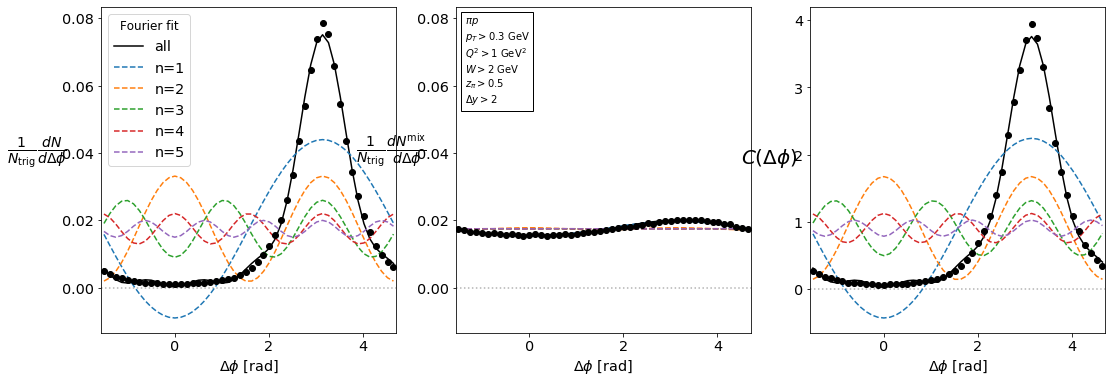

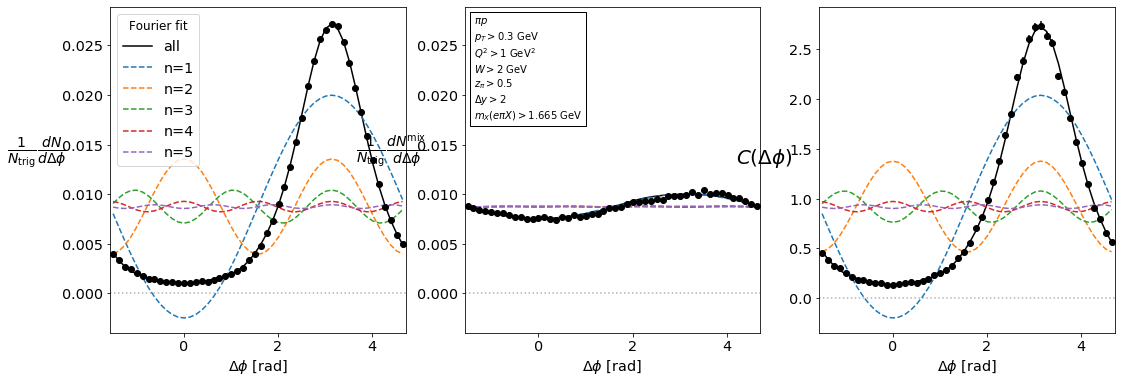

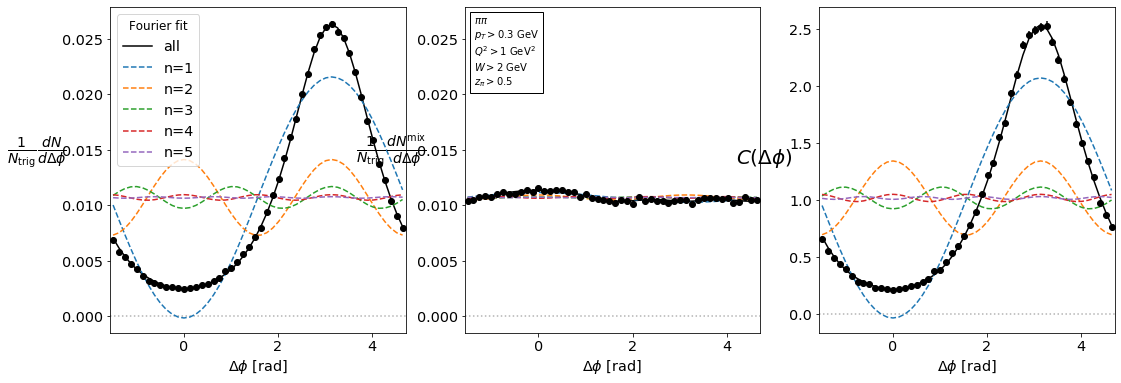

In [26]:
#cm frame

df_trig = data_triggers.query("h_cm_pt>0.3")
df = data_dihadrons.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                         + "and h2_pid == 2212")
fig,axs = azimuthalPlot_3(df,df_trig,n=5)
axs[1].add_artist(AnchoredText("$\pi p$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$z_\\pi>0.5$\n$\\Delta y>2$",loc='upper left'))
plt.show()
df = data_dihadrons.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                         + "and h2_pid == 2212 and mx_eh1x > 1.665")
fig,axs = azimuthalPlot_3(df,df_trig,n=5)
axs[1].add_artist(AnchoredText("$\pi p$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$z_\\pi>0.5$\n$\\Delta y>2$\n$m_X(e\\pi X)> 1.665$ GeV",loc='upper left'))
plt.show()

df = data_dihadrons.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                         + "and abs(h2_pid) == 211")
fig,axs = azimuthalPlot_3(df,df_trig,n=5)
axs[1].add_artist(AnchoredText("$\pi\pi$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$z_\\pi>0.5$",loc='upper left'))
plt.show()

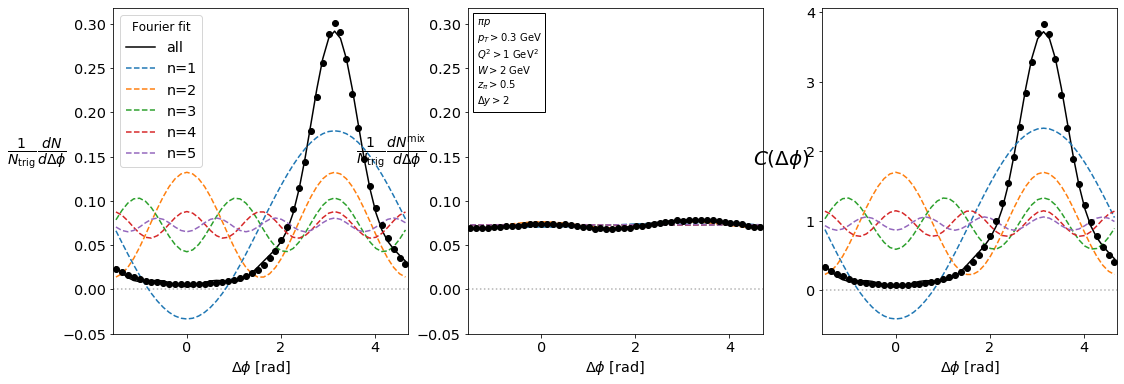

In [27]:
#cm frame  (MC)
df = mc_dihadrons.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                         + "and h2_pid == 2212")
fig,axs = azimuthalPlot_3(df,df_trig,n=5)
axs[1].add_artist(AnchoredText("$\pi p$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$z_\\pi>0.5$\n$\\Delta y>2$",loc='upper left'))
plt.show()


MC RECON


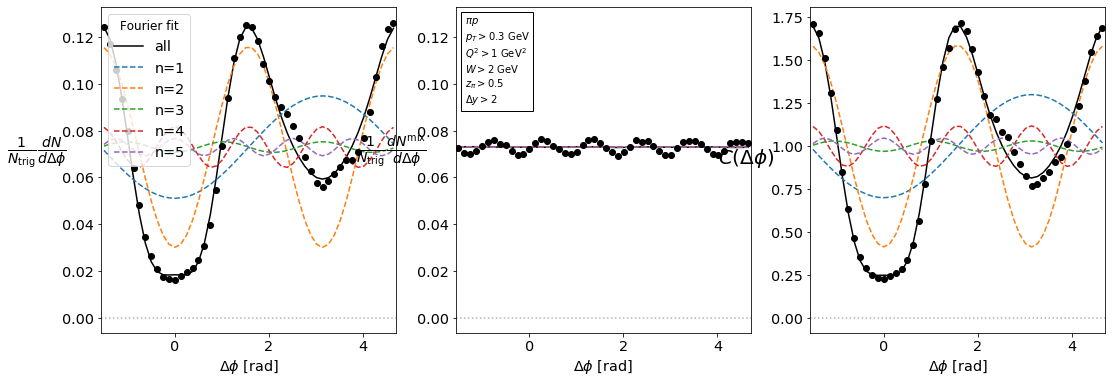

MC TRUTH


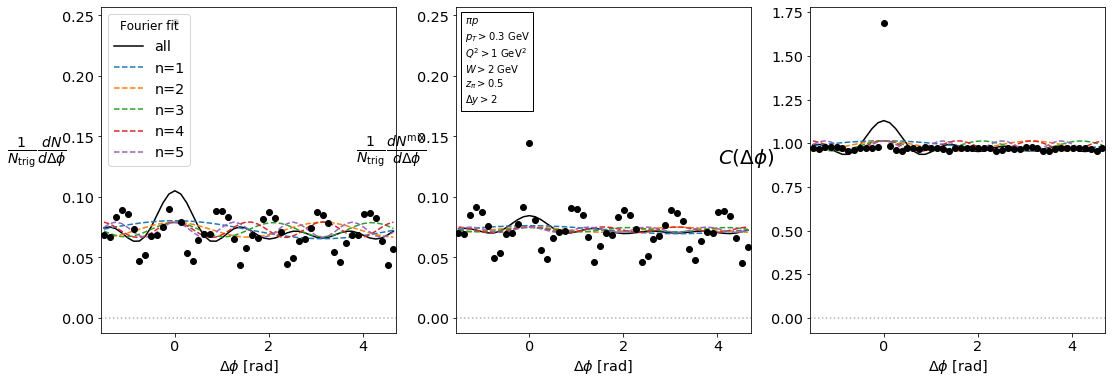

In [28]:
#lab frame MC
print("MC RECON")
df = mc_dihadrons.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                         + "and h2_pid == 2212")
fig,axs = azimuthalPlot_3(df,df_trig,n=5,frame='lab')
axs[1].add_artist(AnchoredText("$\pi p$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$z_\\pi>0.5$\n$\\Delta y>2$",loc='upper left'))
plt.show()
#lab frame MC TRUTH

print("MC TRUTH")
df = mc_dihadrons.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                         + "and h2_pid == 2212")
fig,axs = azimuthalPlot_3(df,df_trig,n=5,frame='lab',truth=True)
axs[1].add_artist(AnchoredText("$\pi p$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$z_\\pi>0.5$\n$\\Delta y>2$",loc='upper left'))
plt.show()

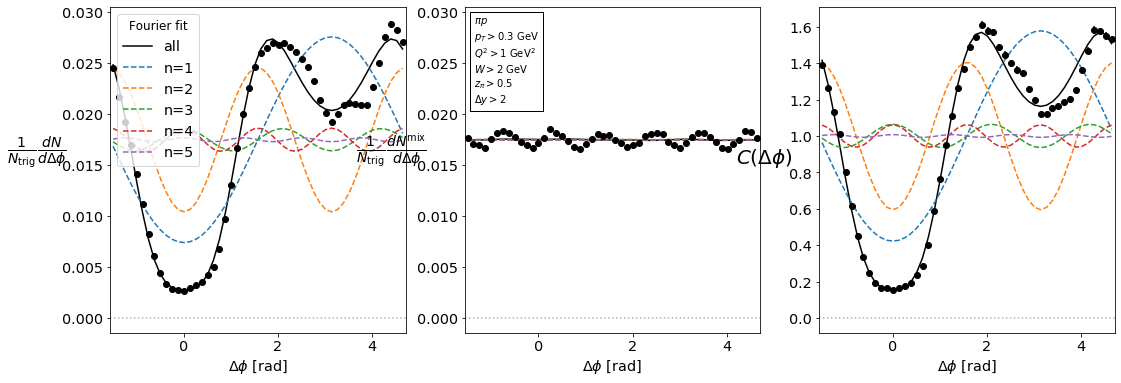

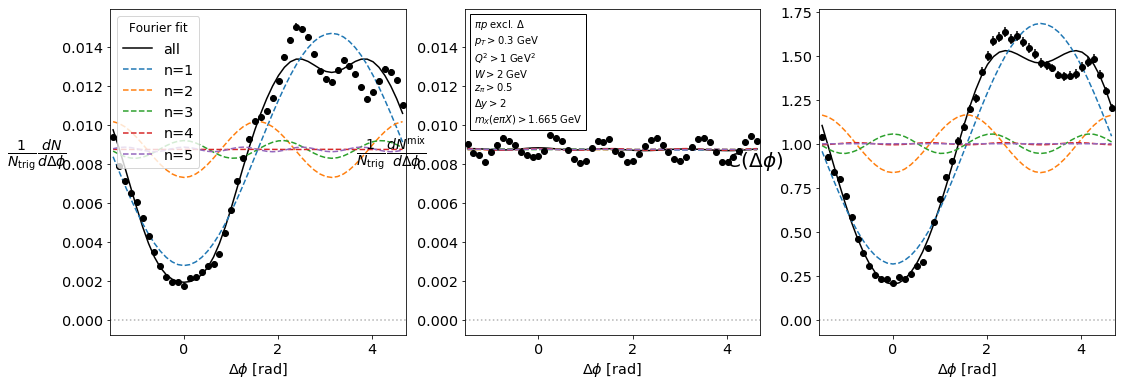

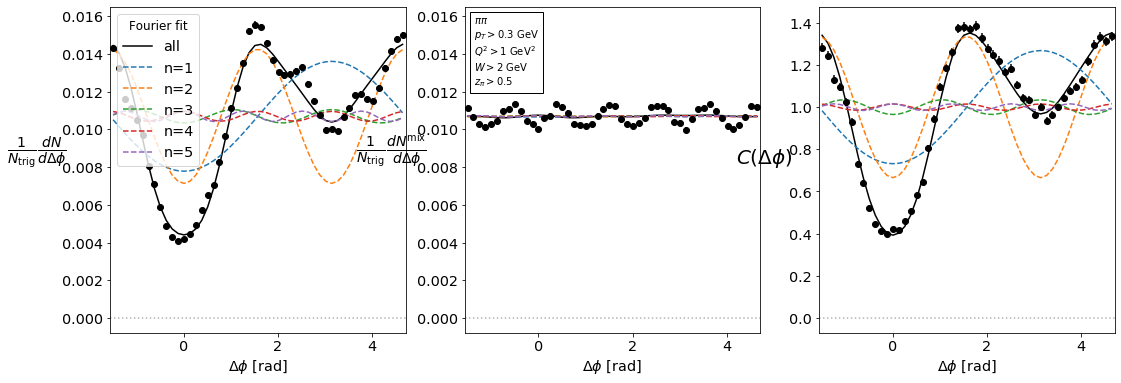

In [29]:
#lab frame
df = data_dihadrons.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                         + "and h2_pid == 2212")
fig,axs = azimuthalPlot_3(df,df_trig,n=5,frame='lab')
axs[1].add_artist(AnchoredText("$\pi p$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$z_\\pi>0.5$\n$\\Delta y>2$",loc='upper left'))
plt.show()

df = data_dihadrons.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                         + "and h2_pid == 2212 and mx_eh1x > 1.665")
fig,axs = azimuthalPlot_3(df,df_trig,n=5,frame='lab')
axs[1].add_artist(AnchoredText("$\pi p$ excl. $\Delta$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$z_\\pi>0.5$\n$\\Delta y>2$\n$m_X(e\\pi X)> 1.665$ GeV",loc='upper left'))
plt.show()

df = data_dihadrons.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                         + "and abs(h2_pid) == 211")
fig,axs = azimuthalPlot_3(df,df_trig,n=5,frame='lab')
axs[1].add_artist(AnchoredText("$\pi\pi$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$z_\\pi>0.5$",loc='upper left'))
plt.show()

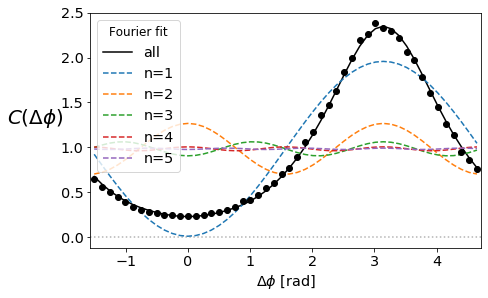

In [96]:
df = data_dihadrons.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                         + "and abs(h2_pid) == 211")
azimuthalPlot(df,df_trig,n=5)

<ipython-input-24-e7abf3efcec0>:34: RuntimeWarning: invalid value encountered in true_divide
  dy = y/ym*np.hypot(dy/y, dym/ym)
<ipython-input-24-e7abf3efcec0>:35: RuntimeWarning: invalid value encountered in true_divide
  y= y/ym


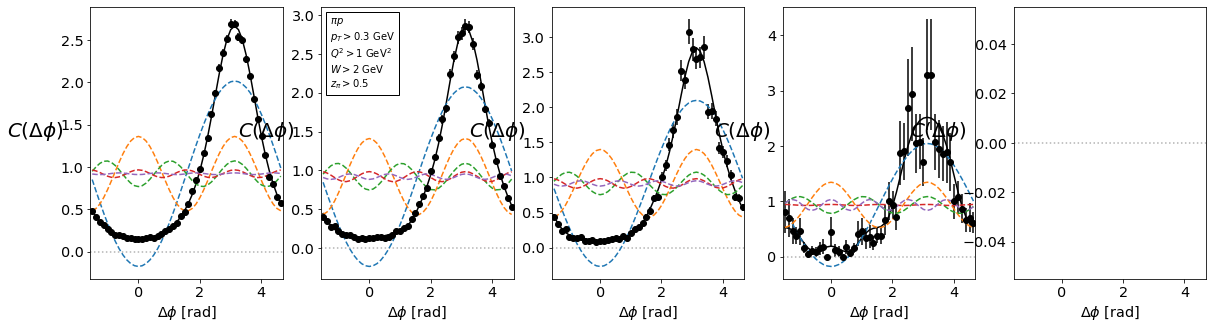

In [30]:
df = data_dihadrons.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                         + "and h2_pid == 2212 and mx_eh1x >1.665")

partitions = [0.5, 0.6,0.7,0.8,0.9,1.0]
fig,axs = plt.subplots(1,len(partitions)-1,figsize=(20,5))
for i, (mn,mx) in enumerate(zip(partitions[:-1],partitions[1:])):
    dfbin = df.query('h1_z>%s and h1_z<%s'%(mn,mx))
    plt.sca(axs[i])
    azimuthalPlot(dfbin,df_trig,n=5,show='corr',includeLegend=False)
axs[1].add_artist(AnchoredText("$\pi p$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$z_\\pi>0.5$",loc='upper left'))
plt.show()
            

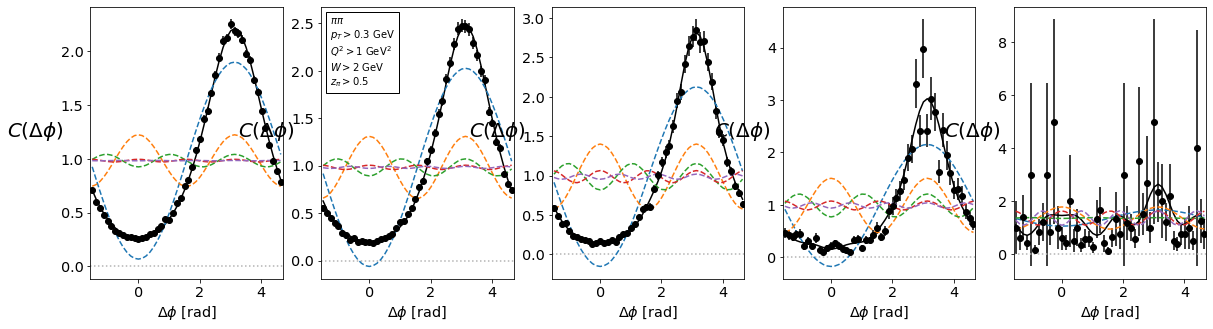

In [123]:
df = data_dihadrons.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                         + "and abs(h2_pid) == 211")

partitions = [0.5, 0.6,0.7,0.8,0.9,1.0]
fig,axs = plt.subplots(1,len(partitions)-1,figsize=(20,5))
for i, (mn,mx) in enumerate(zip(partitions[:-1],partitions[1:])):
    dfbin = df.query('h1_z>%s and h1_z<%s'%(mn,mx))
    plt.sca(axs[i])
    azimuthalPlot(dfbin,df_trig,n=5,show='corr',includeLegend=False)
axs[1].add_artist(AnchoredText("$\pi\pi$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$z_\\pi>0.5$",loc='upper left'))
plt.show()

<ipython-input-107-86d04697ff2b>:24: RuntimeWarning: invalid value encountered in true_divide
  dy = y/ym*np.hypot(dy/y, dym/ym)
<ipython-input-107-86d04697ff2b>:24: RuntimeWarning: divide by zero encountered in true_divide
  dy = y/ym*np.hypot(dy/y, dym/ym)
<ipython-input-107-86d04697ff2b>:25: RuntimeWarning: divide by zero encountered in true_divide
  y= y/ym
<ipython-input-107-86d04697ff2b>:37: RuntimeWarning: invalid value encountered in double_scalars
  b = [2*sum(y*np.cos(i*x))/len(x) for i in range(0,n+1)]


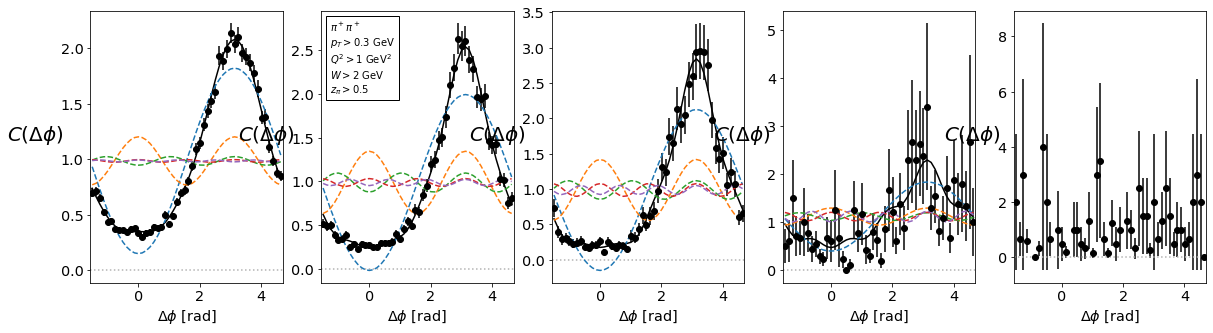

In [124]:
df = data_dihadrons.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                         + "and h2_pid == 211 and h1_pid == 211")

partitions = [0.5, 0.6,0.7,0.8,0.9,1.0]
fig,axs = plt.subplots(1,len(partitions)-1,figsize=(20,5))
for i, (mn,mx) in enumerate(zip(partitions[:-1],partitions[1:])):
    dfbin = df.query('h1_z>%s and h1_z<%s'%(mn,mx))
    plt.sca(axs[i])
    azimuthalPlot(dfbin,df_trig,n=5,show='corr',includeLegend=False)
axs[1].add_artist(AnchoredText("$\pi^+\pi^+$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$z_\\pi>0.5$",loc='upper left'))
plt.show()

(array([      0.,       0.,       0.,       0.,       0., 1672821.,
              0.,       0.,       0.,       0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <a list of 10 Patch objects>)

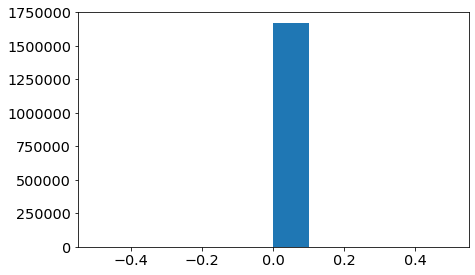